### Import dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score


### Load model

In [2]:
MODEL_NAME = "google/flan-t5-small"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Load dataset

In [3]:
TEST_DATASET_PATH = os.path.join("data", "test.csv")

test_dataset = load_dataset('csv', data_files=TEST_DATASET_PATH)['train']

### Evaluate model

In [4]:
def classify_review(text):
    input_text = f"""
Please rate the review below on a scale from 1 to 5:
1 - Very Bad, 2 - Bad, 3 - Fair, 4 - Good, 5 - Excellent

Review:
{text}

Please enter your rating here: 
    """.strip()
    input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).input_ids
    outputs = model.generate(input_ids, max_new_tokens=5)
    predicted_rating_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    try:
        predicted_rating = int(predicted_rating_text)
    except ValueError:
        predicted_rating = None
    return predicted_rating

In [5]:
results = []

progress_bar = tqdm(total=len(test_dataset['text']))
for i, review in enumerate(test_dataset['text']):
    time_start = time.time()
    rating_predicted = classify_review(review)
    time_end = time.time()
    
    results.append({
        "review": review,
        "rating": test_dataset['label'][i],
        "rating_predicted": rating_predicted,
        "time": time_end - time_start
    })
    
    progress_bar.update(1)
    
df_eval = pd.DataFrame(results)

100%|██████████| 3074/3074 [02:28<00:00, 20.28it/s]

### Evaluation Results

In [6]:
def plot_confusion_matrix(cm_df):
    sorted_index = sorted(cm_df.index, key=lambda x: str(x))
    sorted_columns = sorted(cm_df.columns, key=lambda x: str(x))
    cm_df = cm_df.loc[sorted_index, sorted_columns]

    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(cm_df, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    # Setting tick marks and labels
    ax.set(xticks=np.arange(cm_df.shape[1]),
           yticks=np.arange(cm_df.shape[0]),
           xticklabels=sorted_columns, yticklabels=sorted_index,
           title='Confusion Matrix',
           ylabel='Actual labels',
           xlabel='Predicted labels')

    # Rotate the tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'  # Use 'd' for integers, 'g' for more general formats
    thresh = cm_df.values.max() / 2.  # Threshold for text color contrast
    for i in range(cm_df.shape[0]):
        for j in range(cm_df.shape[1]):
            ax.text(j, i, format(cm_df.iat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_df.iat[i, j] > thresh else "black")
    
    fig.tight_layout()
    plt.show()

/Users/andrejkartavik/miniconda3/envs/pjn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


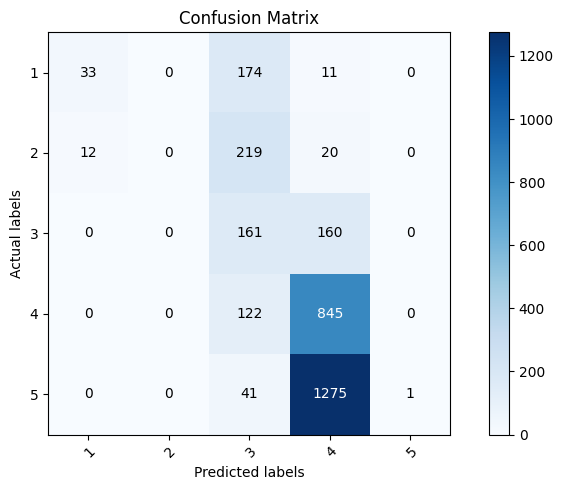

Accuracy: 0.3383214053350683
Recall: 0.30550593773932033
Precision: 0.46470452695162967
F1 Score: 0.2156476468622548
Average time per review: 0.047648537368377306


In [7]:
def compute_metrics(df, true_col, pred_col):
    # Calculate confusion matrix
    labels = df[true_col].unique()
    cm = confusion_matrix(df[true_col], df[pred_col], labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(df[true_col], df[pred_col])
    recall = recall_score(df[true_col], df[pred_col], average='macro')
    precision = precision_score(df[true_col], df[pred_col], average='macro')
    f1 = f1_score(df[true_col], df[pred_col], average='macro')
    
    avg_time = df['time'].mean()
    
    return cm_df, accuracy, recall, precision, f1, avg_time

cm_df, accuracy, recall, precision, f1, avg_time = compute_metrics(df_eval, 'rating', 'rating_predicted')
plot_confusion_matrix(cm_df)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Average time per review:", avg_time)